# Feature Selection: Correlation & Multicollinearity Analysis
## Loan Default Prediction Project - Updated with Business Logic Protection

This notebook performs comprehensive feature selection through:
1. **Correlation Analysis** - Remove highly correlated features (threshold: 0.9)
2. **Target Correlation** - Identify features with low predictive power (threshold: 0.001)
3. **Multicollinearity (VIF)** - Detect and handle multicollinear features
4. **Mutual Information** - Measure non-linear relationships (threshold: 0.001)
5. **Business-Critical Features Protection** - Never remove domain-important features

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## Define Business-Critical Features

These features are essential for loan default prediction and should never be removed regardless of statistical measures.

In [2]:
# Define business-critical features that should NEVER be removed
business_critical_features = {
    'Credit_Bureau',              # Number of credit inquiries - key risk indicator
    'Active_Loan',                # Current debt obligations
    'House_Own',                  # Major asset ownership
    'Client_Family_Members',      # Total household dependency
    'Has_Credit_Bureau_Record',   # Credit history existence
    'Employment_Years',           # Job stability
    'Client_Income_Type',         # Income source reliability
    'Is_Unemployed',              # Employment status flag
    'Credit_Income_Ratio',        # Debt-to-income ratio
    'Annuity_Income_Ratio',       # Payment burden
    'Monthly_Payment_Burden',     # Monthly cash flow impact
    'Total_Assets_Owned',         # Overall financial stability
    'Age_Years',                  # Life stage indicator
    'Client_Income',              # Base income
    'Credit_Amount',              # Loan size
    'Loan_Annuity'                # Payment amount
}

print(f"🛡️ Defined {len(business_critical_features)} business-critical features")

🛡️ Defined 16 business-critical features


## Step 1: Load Processed Data

In [3]:
# Load the processed data
X = pd.read_csv('processed_data/X_processed.csv')
y = pd.read_csv('processed_data/y_target.csv').squeeze()

print(f"✓ Features loaded: {X.shape}")
print(f"✓ Target loaded: {y.shape}")
print(f"✓ Default rate: {y.mean():.2%}")

# Display first few rows
X.head()

✓ Features loaded: (121856, 56)
✓ Target loaded: (121856,)
✓ Default rate: 8.08%


,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Has_House_Age_Info,Score_Source_1_Available,Score_Source_2_Available,Score_Source_3_Available,Num_Credit_Scores_Available,Has_Credit_Bureau_Record,Social_Circle_Data_Available,Has_Employment_History,Occupation_Disclosed,Credit_Income_Ratio,Annuity_Income_Ratio,Monthly_Payment_Burden,Credit_Annuity_Ratio,Is_Unemployed,Employment_Years,Age_Years,Total_Assets_Owned,Min_External_Score
0,6750.0,0,0,1,0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,-13957.0,-1062.0,-6123.0,-383.0,0.0,1,1,0,Sales,2.0,2.0,6.0,17.0,1,1,Self-employed,0.568066,0.478787,0.000000,0.0186,63.0,0.0,0,1,1,0,2,0,1,1,1,9.063924,0.506125,6.073500,17.903229,0,2.9,38.2,0,0.000000
1,20250.0,1,0,1,0,0.0,15282.00,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,-14162.0,-4129.0,-7833.0,-21.0,0.0,1,0,1,Not_Disclosed,2.0,2.0,3.0,10.0,1,1,Government,0.563360,0.215068,0.000000,0.0000,755.0,0.0,0,1,1,0,2,0,0,1,0,0.754629,0.090196,1.082347,8.362015,0,11.3,38.8,1,0.000000
2,18000.0,0,0,1,0,1.0,59527.35,2788.20,Alone,Service,Graduation dropout,W,Male,CL,Family,0.022800,-16790.0,-5102.0,-4493.0,-331.0,0.0,1,0,0,Realty agents,2.0,2.0,4.0,12.0,1,1,Self-employed,0.000000,0.552795,0.329655,0.0742,277.0,0.0,0,0,1,1,2,0,1,1,1,3.306891,0.154891,1.858697,21.342087,0,14.0,46.0,0,0.000000
3,15750.0,0,0,1,1,0.0,53870.40,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,-23195.0,-1649.0,-4493.0,-775.0,9.0,1,0,0,Not_Disclosed,2.0,3.0,2.0,15.0,1,1,Not_Disclosed,0.000000,0.135182,0.631355,0.0000,1700.0,3.0,1,0,1,1,2,1,0,1,0,3.420126,0.145734,1.748803,23.458120,0,4.5,63.5,1,0.000000
4,33750.0,1,0,1,0,2.0,133988.40,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,-11366.0,-2977.0,-5516.0,-4043.0,6.0,1,0,0,Laborers,4.0,1.0,3.0,12.0,1,1,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,1,1,1,1,3,1,1,1,1,3.969909,0.105104,1.261243,37.760762,0,8.2,31.1,1,0.301182


## Step 2: Feature Overview & Basic Checks

In [4]:
# Separate features by type
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"📊 Feature Types:")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features: {len(categorical_features)}")
print(f"  - Total features: {X.shape[1]}")

# Check which business-critical features are present
protected_features = [f for f in business_critical_features if f in X.columns]
print(f"\n🛡️ Business-critical features present: {len(protected_features)}")

print("\n📋 Categorical features:")
for i, feat in enumerate(categorical_features, 1):
    print(f"  {i}. {feat}")

📊 Feature Types:
  - Numeric features: 47
  - Categorical features: 9
  - Total features: 56

🛡️ Business-critical features present: 16

📋 Categorical features:
  1. Accompany_Client
  2. Client_Income_Type
  3. Client_Education
  4. Client_Marital_Status
  5. Client_Gender
  6. Loan_Contract_Type
  7. Client_Housing_Type
  8. Client_Occupation
  9. Type_Organization


In [5]:
# Check for constant features (only one unique value)
constant_features = []
for col in X.columns:
    if X[col].nunique() <= 1:
        constant_features.append(col)

if constant_features:
    print(f"⚠️  Found {len(constant_features)} constant features to remove:")
    for feat in constant_features:
        print(f"    - {feat}")
    X = X.drop(columns=constant_features)
    numeric_features = [f for f in numeric_features if f not in constant_features]
else:
    print("✓ No constant features found")

✓ No constant features found


## Step 3: Correlation Analysis Between Features

We'll identify pairs of features with high correlation (|r| > 0.9) as they provide redundant information.

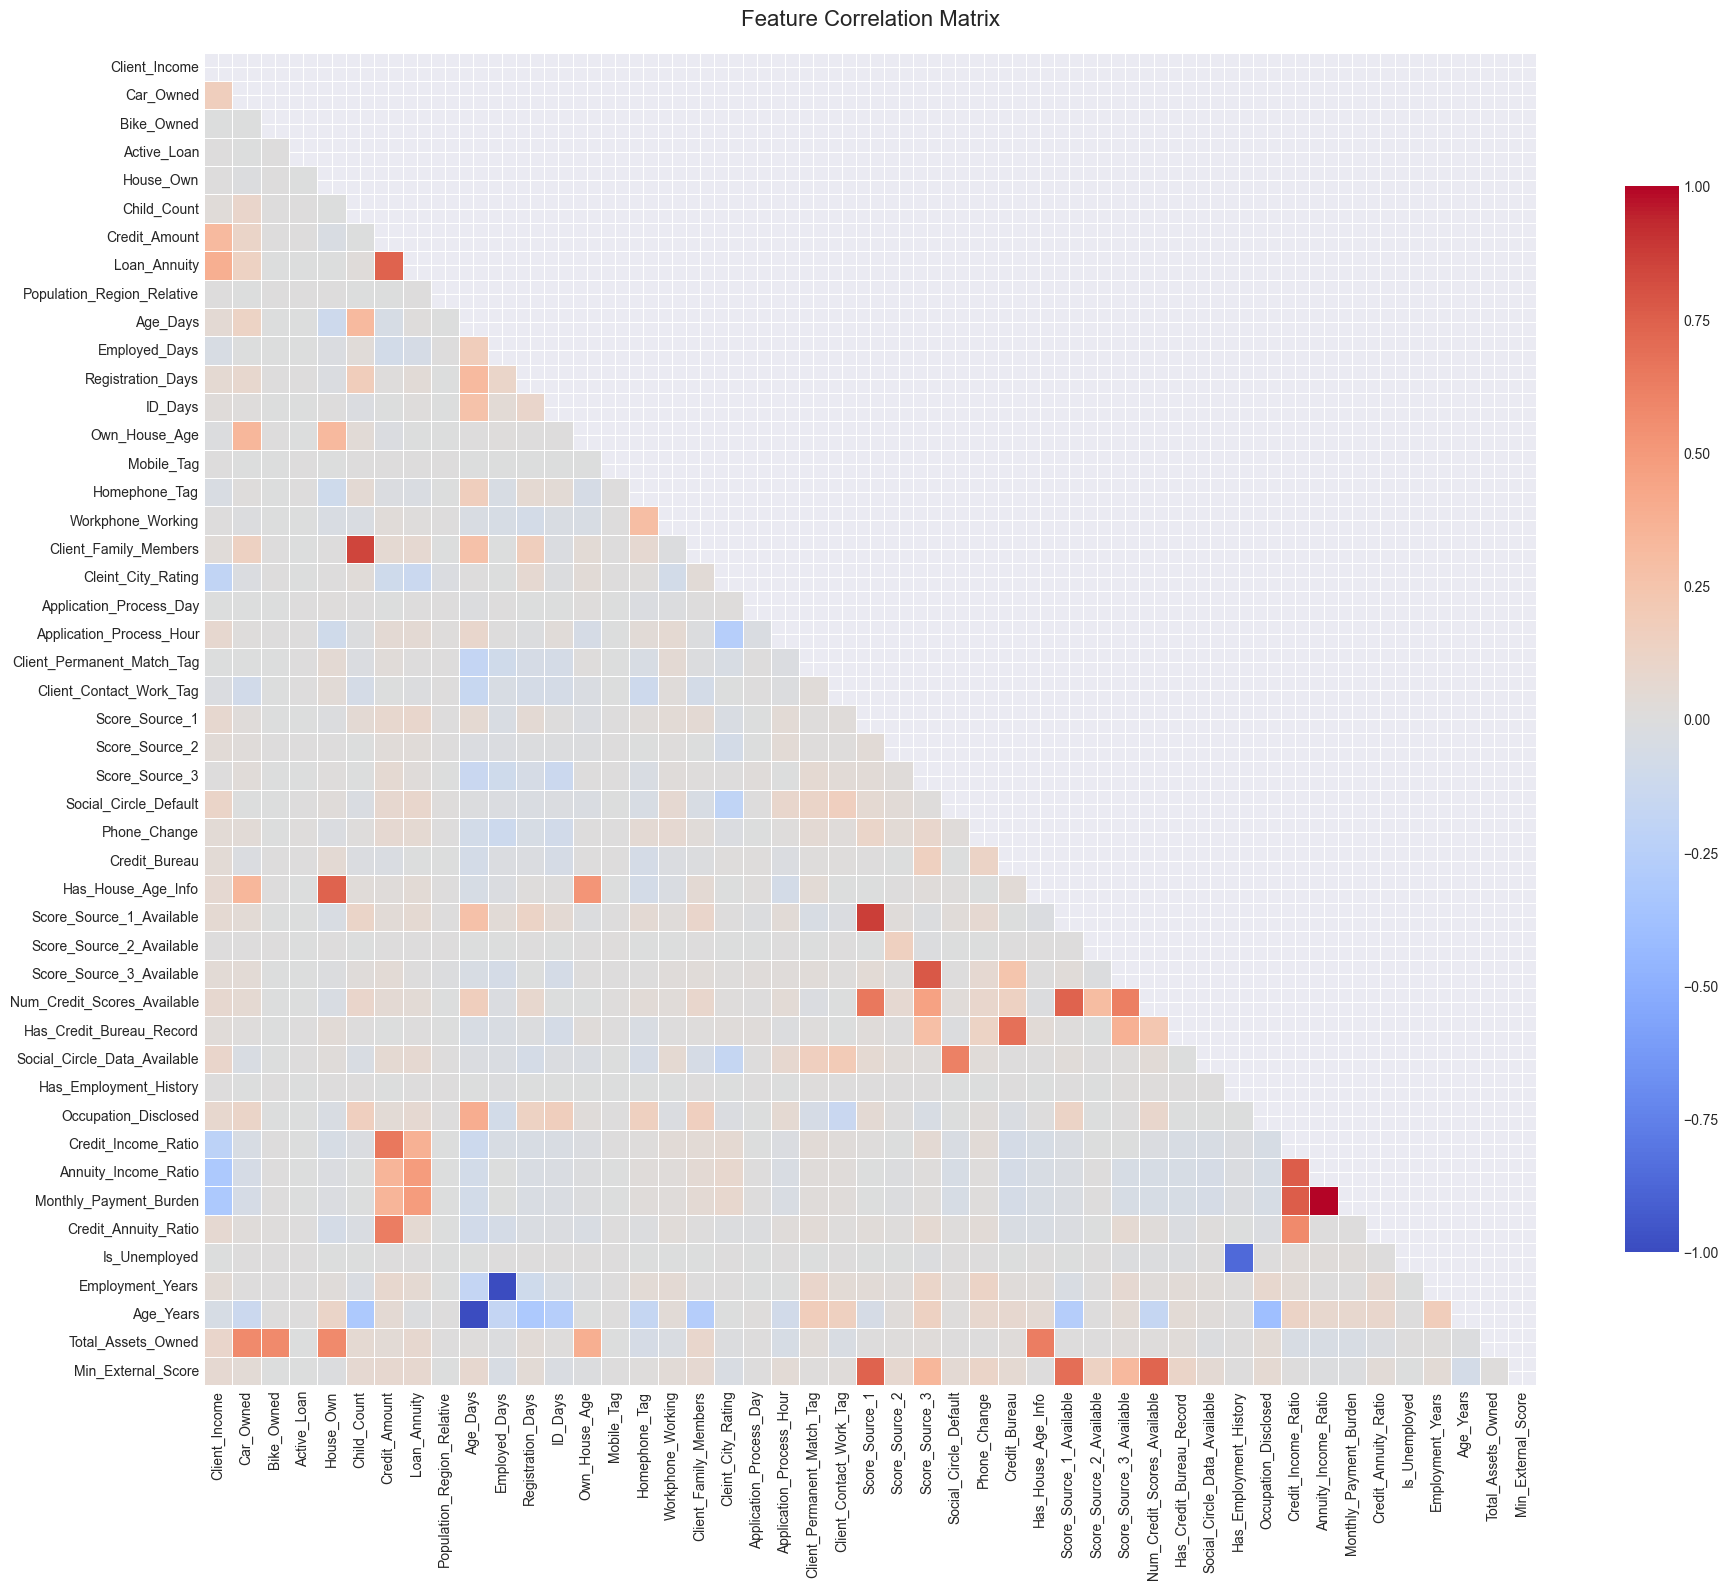

In [6]:
# Calculate correlation matrix for numeric features
numeric_data = X[numeric_features]
corr_matrix = numeric_data.corr()

# Visualize correlation matrix
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot=False)
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [7]:
corr_matrix

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Has_House_Age_Info,Score_Source_1_Available,Score_Source_2_Available,Score_Source_3_Available,Num_Credit_Scores_Available,Has_Credit_Bureau_Record,Social_Circle_Data_Available,Has_Employment_History,Occupation_Disclosed,Credit_Income_Ratio,Annuity_Income_Ratio,Monthly_Payment_Burden,Credit_Annuity_Ratio,Is_Unemployed,Employment_Years,Age_Years,Total_Assets_Owned,Min_External_Score
Client_Income,1.000000,0.167367,-0.004133,0.002182,0.003934,0.025258,0.317541,0.390341,0.002405,0.050864,-0.046364,0.057486,0.023385,-0.011274,0.001056,-0.039024,0.001170,0.028580,-0.187803,-0.001709,0.076010,-0.006986,-0.015770,0.077029,0.035091,0.001597,0.114524,0.039321,0.039896,0.063122,0.058961,0.007616,0.046217,0.072714,0.030757,0.099006,0.004550,0.079970,-0.225376,-0.318322,-0.318322,0.064125,-0.004113,0.046506,-0.050863,0.097118,0.065528
Car_Owned,0.167367,1.000000,-0.000330,-0.001541,-0.008882,0.096511,0.110984,0.135097,-0.001550,0.127765,-0.003258,0.081046,0.014664,0.339715,-0.004056,0.011595,-0.008947,0.143923,-0.021865,-0.005144,0.013681,-0.002886,-0.088579,0.020154,0.015916,0.026831,-0.007590,0.034673,-0.015865,0.341490,0.044676,0.002739,0.039713,0.056999,0.010484,-0.032388,-0.000726,0.113812,-0.040365,-0.060543,-0.060543,0.016771,0.002490,0.003422,-0.127766,0.575551,0.040979
Bike_Owned,-0.004133,-0.000330,1.000000,0.001769,0.002165,0.001411,0.004963,-0.000931,0.005867,-0.000828,-0.000106,0.004752,-0.000704,0.004102,-0.004153,-0.002693,-0.006119,0.002880,0.000995,-0.003600,0.001775,-0.001446,-0.003657,-0.003587,0.001249,-0.003065,-0.002885,-0.004937,0.000482,0.004703,-0.002477,0.000754,-0.000587,-0.001908,-0.000558,-0.000689,0.001255,-0.002635,0.007404,0.001525,0.001525,0.008242,0.000164,0.000100,0.000826,0.577238,-0.004566
Active_Loan,0.002182,-0.001541,0.001769,1.000000,-0.006380,0.000812,0.000499,-0.001284,0.004380,-0.000881,-0.001913,0.000774,-0.000021,-0.003772,0.002776,0.000941,-0.000310,-0.001314,-0.003341,0.000559,0.004590,0.005738,0.004121,-0.003809,0.000254,-0.001522,0.007226,0.008558,0.006259,-0.003062,-0.004513,-0.004232,-0.004159,-0.007060,0.002300,0.005380,-0.002282,-0.003001,-0.001072,-0.002481,-0.002481,0.003215,0.000221,0.001922,0.000888,-0.003571,-0.003343
House_Own,0.003934,-0.008882,0.002165,-0.006380,1.000000,-0.003275,-0.036805,-0.003068,0.003109,-0.112737,-0.021143,-0.022222,0.007155,0.327889,-0.002005,-0.106091,-0.037834,0.007477,0.002641,0.010996,-0.098823,0.054618,0.033302,-0.008436,0.000400,0.009548,0.017132,-0.022154,0.047835,0.737319,-0.038595,0.002471,-0.010533,-0.033416,0.038286,0.018774,0.000798,-0.037434,-0.046985,-0.018490,-0.018490,-0.064474,-0.002558,0.021071,0.112731,0.575179,-0.014203
Child_Count,0.025258,0.096511,0.001411,0.000812,-0.003275,1.000000,-0.001448,0.020353,-0.003249,0.315428,0.025329,0.172790,-0.022527,0.033060,0.001610,0.050906,-0.028979,0.850233,0.023959,0.000104,-0.009281,-0.017706,-0.065423,0.053659,-0.006107,-0.006189,-0.025927,0.008818,-0.022773,0.026255,0.113433,-0.000185,0.020584,0.094125,0.003586,-0.035913,0.001745,0.161110,-0.018725,-0.003301,-0.003301,-0.028349,-0.003943,-0.025076,-0.315431,0.054978,0.069324
Credit_Amount,0.317541,0.110984,0.004963,0.000499,-0.036805,-0.001448,1.000000,0.740960,-0.000157,-0.052370,-0.085539,0.008532,-0.004842,-0.020629,0.002301,-0.021597,0.029868,0.056980,-0.108128,-0.005263,0.052489,0.026233,-0.002113,0.082286,0.029923,0.056590,0.072267,0.068057,-0.024692,0.016121,0.032229,0.003595,0.044020,0.050887,-0.007572,0.057409,-0.002771,0.039091,0.653311,0.348394,0.348394,0.632258,0.005924,0.085

In [8]:
# Find highly correlated feature pairs
# def find_high_correlations(corr_matrix, threshold=0.9):
#     """Find feature pairs with correlation above threshold"""
#     high_corr_pairs = []
    
#     # Get upper triangle of correlation matrix
#     upper_triangle = np.triu(corr_matrix, k=1)
    
#     # Find indices where correlation > threshold
#     high_corr_indices = np.where(np.abs(upper_triangle) > threshold)
    
#     # Get feature names for high correlations
#     for i, j in zip(high_corr_indices[0], high_corr_indices[1]):
#         feature1 = corr_matrix.columns[i]
#         feature2 = corr_matrix.columns[j]
#         correlation = corr_matrix.iloc[i, j]
#         high_corr_pairs.append({
#             'Feature_1': feature1,
#             'Feature_2': feature2,
#             'Correlation': correlation
#         })
    
#     return pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
#                                                      ascending=False, 
#                                                      key=abs)

# Find highly correlated feature pairs
def find_high_correlations(corr_matrix, threshold=0.9):
    """Find feature pairs with correlation above threshold"""
    high_corr_pairs = []
    
    # Get upper triangle of correlation matrix
    upper_triangle = np.triu(corr_matrix, k=1)
    
    # Find indices where correlation > threshold
    high_corr_indices = np.where(np.abs(upper_triangle) > threshold)
    
    # Get feature names for high correlations
    for i, j in zip(high_corr_indices[0], high_corr_indices[1]):
        feature1 = corr_matrix.columns[i]
        feature2 = corr_matrix.columns[j]
        correlation = corr_matrix.iloc[i, j]
        high_corr_pairs.append({
            'Feature_1': feature1,
            'Feature_2': feature2,
            'Correlation': correlation
        })
    
    # Create DataFrame and sort only if there are pairs
    if high_corr_pairs:
        return pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
                                                         ascending=False, 
                                                         key=abs)
    else:
        # Return empty DataFrame with correct columns
        return pd.DataFrame(columns=['Feature_1', 'Feature_2', 'Correlation'])

# Find high correlations with conservative threshold
high_corr_df = find_high_correlations(corr_matrix, threshold=0.9)

if len(high_corr_df) > 0:
    print(f"⚠️  Found {len(high_corr_df)} highly correlated feature pairs (|r| > 0.9):")
    display(high_corr_df)
else:
    print("✓ No highly correlated feature pairs found (|r| > 0.9)")
    
    

# Find high correlations with conservative threshold
high_corr_df = find_high_correlations(corr_matrix, threshold=0.9)

if len(high_corr_df) > 0:
    print(f"⚠️  Found {len(high_corr_df)} highly correlated feature pairs (|r| > 0.9):")
    display(high_corr_df)
else:
    print("✓ No highly correlated feature pairs found (|r| > 0.9)")

⚠️  Found 3 highly correlated feature pairs (|r| > 0.9):


,Feature_1,Feature_2,Correlation
2,Annuity_Income_Ratio,Monthly_Payment_Burden,1.000000
0,Age_Days,Age_Years,-0.999997
1,Employed_Days,Employment_Years,-0.999989


⚠️  Found 3 highly correlated feature pairs (|r| > 0.9):


,Feature_1,Feature_2,Correlation
2,Annuity_Income_Ratio,Monthly_Payment_Burden,1.000000
0,Age_Days,Age_Years,-0.999997
1,Employed_Days,Employment_Years,-0.999989


## Step 4: Target Correlation Analysis

Identify features with low correlation to the target variable (Default).

In [9]:
# Calculate correlation with target
target_corr = numeric_data.corrwith(y).abs().sort_values(ascending=False)

print("📊 Top 20 Features Correlated with Default:")
for i, (feature, corr) in enumerate(target_corr.head(20).items(), 1):
    is_critical = '🛡️' if feature in business_critical_features else '  '
    print(f"{i:2d}. {is_critical} {feature:35s} |r| = {corr:.4f}")

📊 Top 20 Features Correlated with Default:
 1.    Score_Source_3                      |r| = 0.1081
 2. 🛡️ Age_Years                           |r| = 0.0730
 3.    Age_Days                            |r| = 0.0730
 4.    Min_External_Score                  |r| = 0.0712
 5.    Score_Source_1                      |r| = 0.0651
 6.    Employed_Days                       |r| = 0.0631
 7. 🛡️ Employment_Years                    |r| = 0.0630
 8.    Cleint_City_Rating                  |r| = 0.0583
 9.    Phone_Change                        |r| = 0.0538
10.    ID_Days                             |r| = 0.0527
11.    Client_Permanent_Match_Tag          |r| = 0.0425
12.    Social_Circle_Default               |r| = 0.0416
13.    Social_Circle_Data_Available        |r| = 0.0404
14.    Registration_Days                   |r| = 0.0379
15.    Score_Source_2                      |r| = 0.0363
16.    Occupation_Disclosed                |r| = 0.0352
17. 🛡️ Credit_Amount                       |r| = 0.0305
18.  

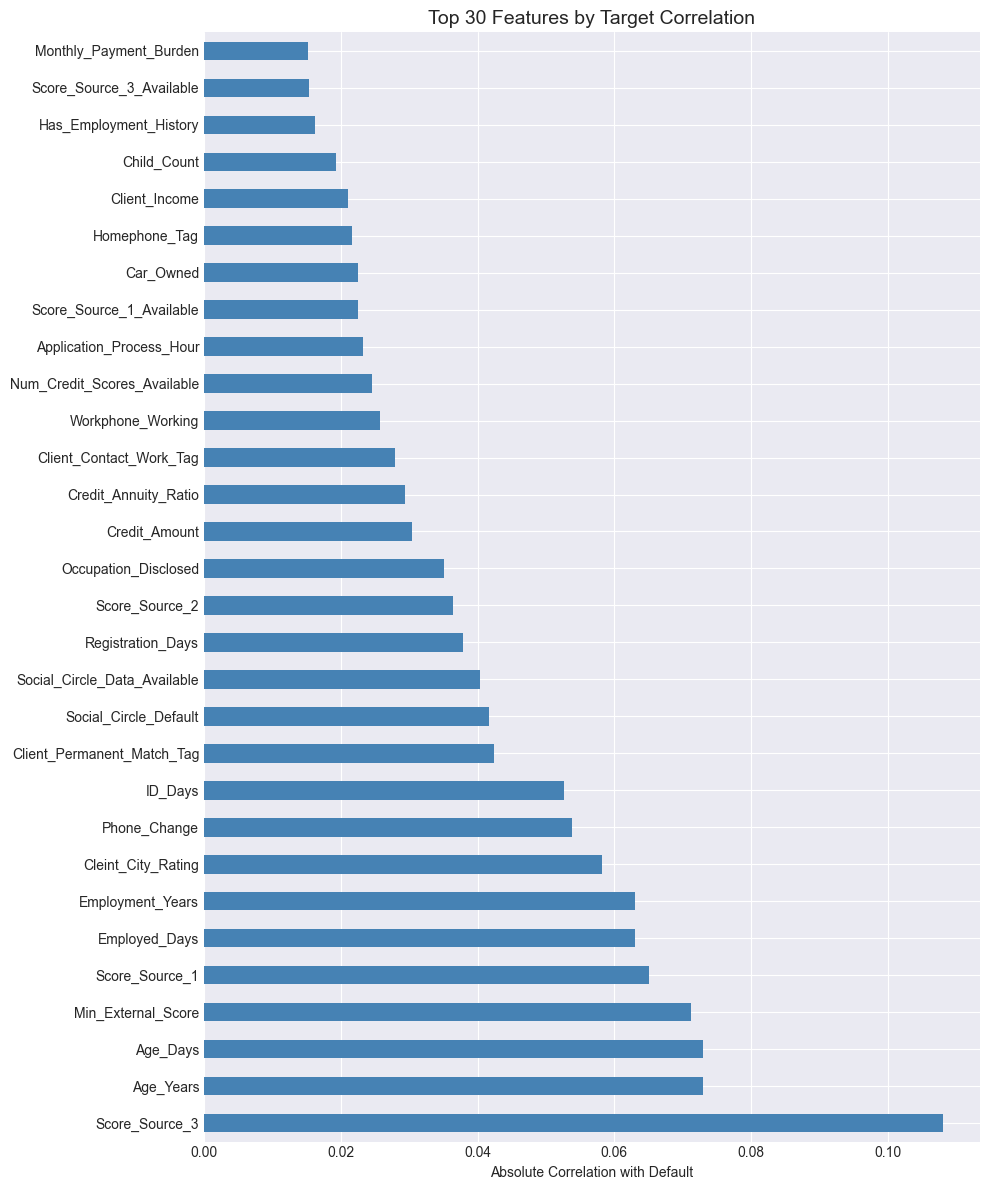

In [10]:
# Visualize target correlations
plt.figure(figsize=(10, 12))
target_corr.head(30).plot(kind='barh', color='steelblue')
plt.xlabel('Absolute Correlation with Default')
plt.title('Top 30 Features by Target Correlation', fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
# Identify low correlation features with more conservative threshold
low_corr_threshold = 0.001  # Much more conservative
low_corr_features = target_corr[target_corr < low_corr_threshold].index.tolist()

if low_corr_features:
    print(f"⚠️  Found {len(low_corr_features)} features with very low target correlation (|r| < {low_corr_threshold}):")
    for feat in low_corr_features[:10]:  # Show first 10
        is_critical = '🛡️' if feat in business_critical_features else '  '
        print(f"    {is_critical} - {feat}: |r| = {target_corr[feat]:.4f}")
    if len(low_corr_features) > 10:
        print(f"    ... and {len(low_corr_features) - 10} more")
        
    # Show protected features
    protected_low_corr = [f for f in low_corr_features if f in business_critical_features]
    if protected_low_corr:
        print(f"\n🛡️ {len(protected_low_corr)} business-critical features with low correlation will be protected:")
        for feat in protected_low_corr:
            print(f"    - {feat}")

⚠️  Found 3 features with very low target correlation (|r| < 0.001):
       - Mobile_Tag: |r| = 0.0008
       - Bike_Owned: |r| = 0.0004
    🛡️ - Active_Loan: |r| = 0.0001

🛡️ 1 business-critical features with low correlation will be protected:
    - Active_Loan


## Step 5: Multicollinearity Analysis (VIF)

Variance Inflation Factor (VIF) measures how much the variance of a coefficient increases due to collinearity.
- VIF = 1: No correlation
- VIF > 5: Moderate multicollinearity
- VIF > 10: High multicollinearity (problematic)

In [12]:
# Prepare data for VIF calculation
numeric_data_clean = numeric_data.fillna(0)
numeric_data_clean = numeric_data_clean.replace([np.inf, -np.inf], 0)

print("⏳ Calculating VIF (this may take a minute)...")

# Calculate VIF for all numeric features
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_data_clean.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_clean.values, i) 
                   for i in range(len(numeric_data_clean.columns))]
vif_df = vif_data.sort_values('VIF', ascending=False)

# Display high VIF features
high_vif = vif_df[vif_df['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n⚠️  Features with HIGH multicollinearity (VIF > 10):")
    for _, row in high_vif.iterrows():
        is_critical = '🛡️' if row['Feature'] in business_critical_features else '  '
        print(f"{is_critical} {row['Feature']:35s} VIF = {row['VIF']:,.2f}")

moderate_vif = vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)]
if len(moderate_vif) > 0:
    print(f"\n⚠️  Features with MODERATE multicollinearity (VIF > 5):")
    display(moderate_vif.head(10))

⏳ Calculating VIF (this may take a minute)...

⚠️  Features with HIGH multicollinearity (VIF > 10):
   Car_Owned                           VIF = inf
   Bike_Owned                          VIF = inf
🛡️ House_Own                           VIF = inf
🛡️ Monthly_Payment_Burden              VIF = inf
🛡️ Total_Assets_Owned                  VIF = inf
   Num_Credit_Scores_Available         VIF = inf
   Score_Source_1_Available            VIF = inf
   Score_Source_2_Available            VIF = inf
   Score_Source_3_Available            VIF = inf
🛡️ Annuity_Income_Ratio                VIF = inf
   Age_Days                            VIF = 2,563,331.90
🛡️ Age_Years                           VIF = 2,563,323.00
   Employed_Days                       VIF = 102,235.81
🛡️ Employment_Years                    VIF = 102,141.95
   Mobile_Tag                          VIF = 40,729.16
   Has_Employment_History              VIF = 40,664.55
🛡️ Credit_Amount                       VIF = 42.59
🛡️ Credit_Income_Rati

,Feature,VIF
23,Score_Source_1,9.303273
25,Score_Source_3,9.059483
0,Client_Income,6.303904
22,Client_Contact_Work_Tag,6.114550
12,ID_Days,5.730633
34,Has_Credit_Bureau_Record,5.405638
5,Child_Count,5.003509


## Step 6: Mutual Information Analysis

Mutual Information captures non-linear relationships between features and target.

In [13]:
# Calculate mutual information
print("⏳ Calculating mutual information scores...")

mi_scores = mutual_info_classif(numeric_data_clean, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': numeric_features,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\n📊 Top 20 Features by Mutual Information:")
for idx, row in mi_df.head(20).iterrows():
    is_critical = '🛡️' if row['Feature'] in business_critical_features else '  '
    print(f"{is_critical} {row['Feature']:35s} MI = {row['MI_Score']:.4f}")

# Features with very low mutual information (adjusted threshold)
low_mi_features = mi_df[mi_df['MI_Score'] < 0.001]['Feature'].tolist()
if low_mi_features:
    print(f"\n⚠️  Found {len(low_mi_features)} features with very low mutual information (MI < 0.001)")

⏳ Calculating mutual information scores...

📊 Top 20 Features by Mutual Information:
   Score_Source_2_Available            MI = 0.0259
   Mobile_Tag                          MI = 0.0251
   Client_Contact_Work_Tag             MI = 0.0222
   Score_Source_2                      MI = 0.0218
   Score_Source_3_Available            MI = 0.0216
   Cleint_City_Rating                  MI = 0.0215
   Credit_Annuity_Ratio                MI = 0.0215
   Has_House_Age_Info                  MI = 0.0215
🛡️ Has_Credit_Bureau_Record            MI = 0.0214
🛡️ House_Own                           MI = 0.0207
   Occupation_Disclosed                MI = 0.0206
   Social_Circle_Data_Available        MI = 0.0174
🛡️ Active_Loan                         MI = 0.0172
   Client_Permanent_Match_Tag          MI = 0.0161
   Has_Employment_History              MI = 0.0159
🛡️ Loan_Annuity                        MI = 0.0149
🛡️ Monthly_Payment_Burden              MI = 0.0149
🛡️ Annuity_Income_Ratio                MI = 0.01

## Step 7: Feature Selection Decisions

Based on our analysis, we'll decide which features to remove while protecting business-critical features.

In [14]:
# Collect features to remove
features_to_remove = set()
removal_reasons = {}

# 1. Handle highly correlated pairs
if len(high_corr_df) > 0:
    print("1️⃣ Handling Highly Correlated Pairs:")
    for _, row in high_corr_df.iterrows():
        feat1, feat2 = row['Feature_1'], row['Feature_2']
        corr1 = abs(target_corr.get(feat1, 0))
        corr2 = abs(target_corr.get(feat2, 0))
        
        # Check if either feature is business critical
        if feat1 in business_critical_features and feat2 in business_critical_features:
            print(f"   🛡️ Both '{feat1}' and '{feat2}' are business critical - keeping both")
            continue
        elif feat1 in business_critical_features:
            features_to_remove.add(feat2)
            removal_reasons[feat2] = f"High correlation with {feat1} (r={row['Correlation']:.3f})"
            print(f"   - Remove '{feat2}' (keep '{feat1}' 🛡️ business critical)")
        elif feat2 in business_critical_features:
            features_to_remove.add(feat1)
            removal_reasons[feat1] = f"High correlation with {feat2} (r={row['Correlation']:.3f})"
            print(f"   - Remove '{feat1}' (keep '{feat2}' 🛡️ business critical)")
        else:
            # Remove the feature with lower target correlation
            if corr1 > corr2:
                features_to_remove.add(feat2)
                removal_reasons[feat2] = f"High correlation with {feat1} (r={row['Correlation']:.3f})"
                print(f"   - Remove '{feat2}' (keep '{feat1}')")
            else:
                features_to_remove.add(feat1)
                removal_reasons[feat1] = f"High correlation with {feat2} (r={row['Correlation']:.3f})"
                print(f"   - Remove '{feat1}' (keep '{feat2}')")

# 2. Features with both low correlation and low MI
if len(low_corr_features) > 0 and len(low_mi_features) > 0:
    low_importance_features = set(low_corr_features) & set(low_mi_features)
    
    # Remove business critical features from the low importance set
    low_importance_features = low_importance_features - business_critical_features
    
    if low_importance_features:
        print(f"\n2️⃣ Low Importance Features (low correlation AND low MI):")
        for feat in list(low_importance_features):
            features_to_remove.add(feat)
            removal_reasons[feat] = "Low correlation and mutual information"
            print(f"   - Remove '{feat}'")

print(f"\n📋 SUMMARY:")
print(f"   - Total features: {X.shape[1]}")
print(f"   - Business-critical features protected: {len(protected_features)}")
print(f"   - Features to remove: {len(features_to_remove)}")
print(f"   - Features to keep: {X.shape[1] - len(features_to_remove)}")

1️⃣ Handling Highly Correlated Pairs:
   🛡️ Both 'Annuity_Income_Ratio' and 'Monthly_Payment_Burden' are business critical - keeping both
   - Remove 'Age_Days' (keep 'Age_Years' 🛡️ business critical)
   - Remove 'Employed_Days' (keep 'Employment_Years' 🛡️ business critical)

📋 SUMMARY:
   - Total features: 56
   - Business-critical features protected: 16
   - Features to remove: 2
   - Features to keep: 54


## Step 8: Create Final Feature Set

In [15]:
# Create final feature list
features_to_keep = [col for col in X.columns if col not in features_to_remove]

# Create cleaned dataset
X_selected = X[features_to_keep].copy()

print(f"✓ Original features: {X.shape[1]}")
print(f"✓ Selected features: {X_selected.shape[1]}")
print(f"✓ Features removed: {len(features_to_remove)}")
print(f"✓ Reduction: {(len(features_to_remove)/X.shape[1])*100:.1f}%")

# Verify all business-critical features are kept
kept_critical = [f for f in business_critical_features if f in X_selected.columns]
print(f"\n🛡️ Business-critical features kept: {len(kept_critical)}/{len(protected_features)}")

# Save selected features
X_selected.to_csv('processed_data/X_selected.csv', index=False)
print(f"\n✓ Selected features saved to: processed_data/X_selected.csv")

✓ Original features: 56
✓ Selected features: 54
✓ Features removed: 2
✓ Reduction: 3.6%

🛡️ Business-critical features kept: 16/16

✓ Selected features saved to: processed_data/X_selected.csv


In [16]:
# Display removed features summary
if features_to_remove:
    removal_df = pd.DataFrame([
        {'Feature': feat, 'Reason': removal_reasons.get(feat, 'Unknown')}
        for feat in sorted(features_to_remove)
    ])
    print("\n📋 Features Removed:")
    display(removal_df)
    
    # Save removal recommendations
    removal_df.to_csv('feature_removal_recommendations.csv', index=False)
    print("\n✓ Removal recommendations saved to: feature_removal_recommendations.csv")


📋 Features Removed:


,Feature,Reason
0,Age_Days,High correlation with Age_Years (r=-1.000)
1,Employed_Days,High correlation with Employment_Years (r=-1.000)



✓ Removal recommendations saved to: feature_removal_recommendations.csv


In [17]:
# Final feature summary
selected_numeric = [f for f in features_to_keep if f in numeric_features]
selected_categorical = [f for f in features_to_keep if f in categorical_features]

print("\n🎯 FINAL FEATURE SET:")
print(f"\nNumeric features ({len(selected_numeric)}):")
for i, feat in enumerate(selected_numeric[:15], 1):
    is_critical = '🛡️' if feat in business_critical_features else '  '
    print(f"  {i:2d}. {is_critical} {feat}")
if len(selected_numeric) > 15:
    print(f"  ... and {len(selected_numeric) - 15} more")

print(f"\nCategorical features ({len(selected_categorical)}):")
for i, feat in enumerate(selected_categorical, 1):
    is_critical = '🛡️' if feat in business_critical_features else '  '
    print(f"  {i:2d}. {is_critical} {feat}")


🎯 FINAL FEATURE SET:

Numeric features (45):
   1. 🛡️ Client_Income
   2.    Car_Owned
   3.    Bike_Owned
   4. 🛡️ Active_Loan
   5. 🛡️ House_Own
   6.    Child_Count
   7. 🛡️ Credit_Amount
   8. 🛡️ Loan_Annuity
   9.    Population_Region_Relative
  10.    Registration_Days
  11.    ID_Days
  12.    Own_House_Age
  13.    Mobile_Tag
  14.    Homephone_Tag
  15.    Workphone_Working
  ... and 30 more

Categorical features (9):
   1.    Accompany_Client
   2. 🛡️ Client_Income_Type
   3.    Client_Education
   4.    Client_Marital_Status
   5.    Client_Gender
   6.    Loan_Contract_Type
   7.    Client_Housing_Type
   8.    Client_Occupation
   9.    Type_Organization


## Summary & Next Steps

### What we accomplished:
1. ✅ Protected business-critical features from removal
2. ✅ Used more conservative thresholds (0.9 for correlation, 0.001 for low importance)
3. ✅ Identified and handled correlated feature pairs intelligently
4. ✅ Detected multicollinear features using VIF
5. ✅ Found low-importance features using correlation and MI
6. ✅ Created optimized feature set while preserving domain knowledge

### Key improvements:
- **Credit_Bureau**, **Active_Loan**, **House_Own** and other critical features are now protected
- More conservative removal criteria prevent over-pruning
- Business logic takes precedence over pure statistics

### Next steps:
1. **Train/Test Split** - Split data before encoding (80/20 or 70/30)
2. **Encoding** - Apply appropriate encoding to categorical variables
3. **Scaling** - Normalize numeric features if needed
4. **Model Training** - Train various models with selected features
5. **Feature Importance** - Validate our selections with model-based importance

### Files created:
- `processed_data/X_selected.csv` - Final feature set with business logic preserved
- `feature_removal_recommendations.csv` - Detailed removal decisions
- `feature_correlation_matrix.png` - Correlation heatmap
- `target_correlation_top30.png` - Target correlation plot